<a href="https://colab.research.google.com/github/eacle00/data_science_practice/blob/main/COVID_19_PH_Daily_Forecasting_Model(SARIMA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Apr_9_Report_datetime.csv to Apr_9_Report_datetime.csv


In [5]:
import io
data = io.BytesIO(uploaded['Apr_9_Report_datetime.csv'])

In [6]:
covid = pd.read_csv(data)

In [7]:
covid.head()

,date,daily_cases
0,1/3/2020,0
1,1/4/2020,0
2,1/5/2020,0
3,1/6/2020,0
4,1/7/2020,0


In [8]:
covid['date']=pd.to_datetime(covid['date'])

In [9]:
covid.set_index('date',inplace=True)

In [10]:
covid.describe()

,daily_cases
count,462.000000
mean,1793.047619
std,2099.547714
min,0.000000
25%,221.000000
50%,1410.500000
75%,2259.000000
max,15280.000000


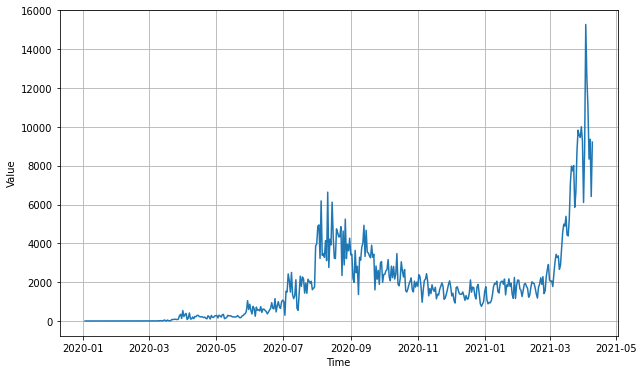

In [11]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='date',y='daily_cases',data=covid)
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)

In [12]:
covid

,daily_cases
date,
2020-01-03,0
2020-01-04,0
2020-01-05,0
2020-01-06,0
2020-01-07,0
...,...
2021-04-05,11028
2021-04-06,8344
2021-04-07,9363


In [13]:
covid_ph=covid.drop(covid.index[:140],axis=0)


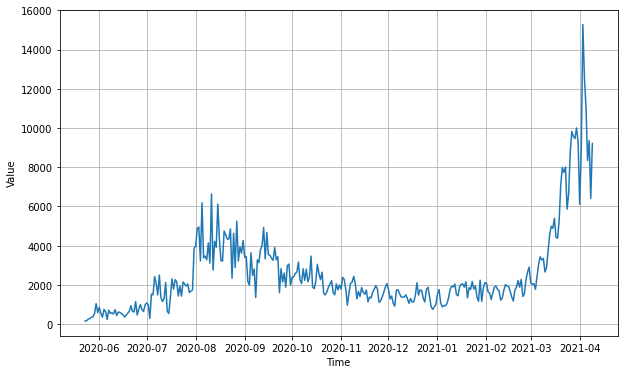

In [14]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='date',y='daily_cases',data=covid_ph)
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)

In [15]:
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
test_result = adfuller(covid_ph['daily_cases'])

In [17]:
def adfuller_test(cases):
  result = adfuller(cases)
  labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
  for value,label in zip(result,labels):
    print(label+' : '+str(value))
  if result[1] <= 0.05:
    print("Strong evidence against the null hypothesis, reject Ho.")
  else:
    print("Weak evidence against null hypothesis, time series has a unit root, it is non_stationary")

In [18]:
adfuller_test(covid_ph['daily_cases'])

ADF Test Statistic : -1.263412948193351
p-value : 0.6457403664956874
#Lags Used : 16
Number of Observations Used : 305
Weak evidence against null hypothesis, time series has a unit root, it is non_stationary


In [19]:
covid_ph['Cases First Difference'] = covid_ph['daily_cases'] - covid_ph['daily_cases'].shift(1)

In [20]:
covid_ph.head()

,daily_cases,Cases First Difference
date,,
2020-05-23,163,NaN
2020-05-24,180,17.0
2020-05-25,258,78.0
2020-05-26,284,26.0
2020-05-27,350,66.0


In [21]:
adfuller_test(covid_ph['Cases First Difference'].dropna())

ADF Test Statistic : -3.010097536157499
p-value : 0.033962117230914905
#Lags Used : 15
Number of Observations Used : 305
Strong evidence against the null hypothesis, reject Ho.


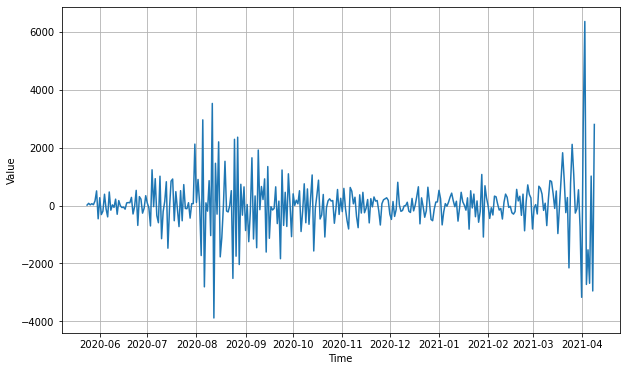

In [22]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='date',y='Cases First Difference',data=covid_ph)
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)

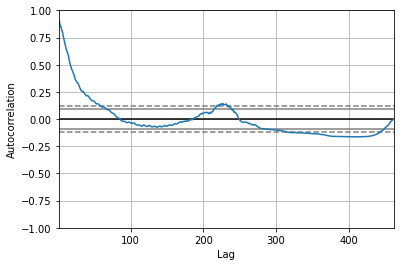

In [23]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(covid['daily_cases'])
plt.show()

In [24]:
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

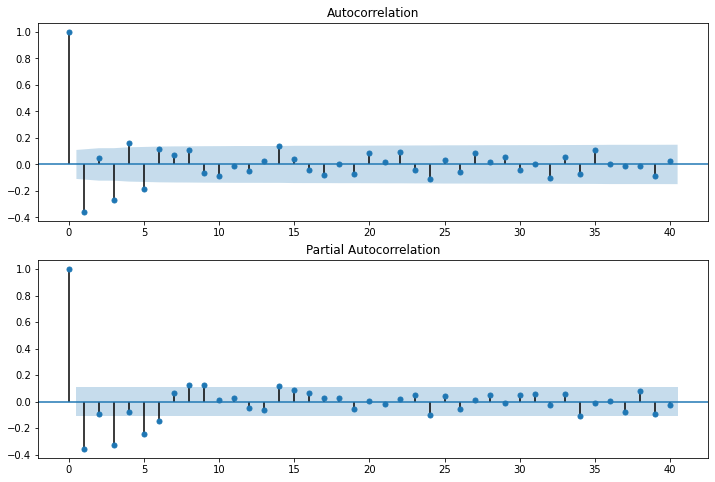

In [25]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(covid_ph['Cases First Difference'].iloc[1:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(covid_ph['Cases First Difference'].iloc[1:],lags=40,ax=ax2)

In [26]:
#p=1, this is from the PACF, q=1, d=1
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(covid_ph['daily_cases'],order=(1,1,2))
model_fit = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [27]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.daily_cases   No. Observations:                  321
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2613.919
Method:                       css-mle   S.D. of innovations            831.672
Date:                Sat, 10 Apr 2021   AIC                           5237.837
Time:                        06:30:18   BIC                           5256.695
Sample:                    05-24-2020   HQIC                          5245.367
                         - 04-09-2021                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  27.8394     16.808      1.656      0.099      -5.104      60.783
ar.L1.D.daily_cases     0.2481      0.189      1.315      0.189      -0.122       0.618
ma.L1.D.daily_cases    -0.7470      0.185     -4.037      0.000      -1.110      -0.384
ma.L2.D.daily_cases     0.0172      0.117      0.147      0.883      -0.213       0.247
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.0308           +0.0000j            4.0308            0.0000
MA.1            1.3828           +0.0000j            1.3828            0.0000
MA.2           42.0384           +0.0000j           42.0384            0.0000
-----------------------------------------------------------------------------
"""

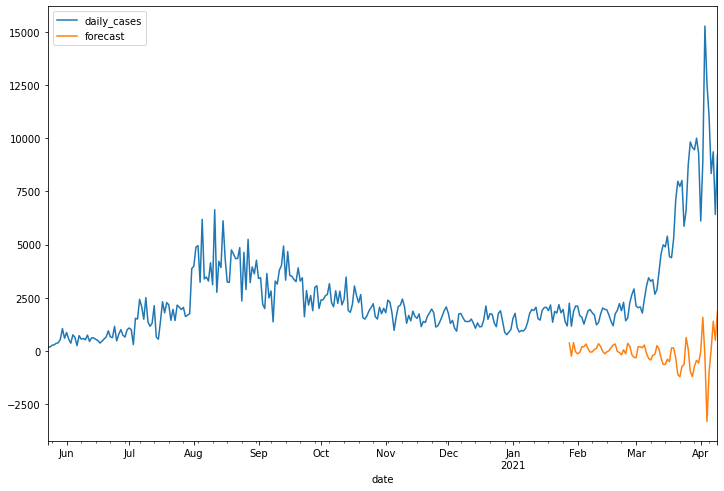

In [28]:
covid_ph['forecast'] = model_fit.predict(start=250,end=325,)
covid_ph[['daily_cases','forecast']].plot(figsize=(12,8))

In [29]:
pd.set_option('display.max_rows',None)

In [30]:
covid_ph

,daily_cases,Cases First Difference,forecast
date,,,
2020-05-23,163,NaN,NaN
2020-05-24,180,17.0,NaN
2020-05-25,258,78.0,NaN
2020-05-26,284,26.0,NaN
2020-05-27,350,66.0,NaN
2020-05-28,380,30.0,NaN
2020-05-29,539,159.0,NaN
2020-05-30,1046,507.0,NaN
2020-05-31,590,-456.0,NaN


In [31]:
import statsmodels.api as sm

In [32]:
model = sm.tsa.statespace.SARIMAX(covid_ph['daily_cases'],order=(1,1,1),seasonal_order=(1,1,1,1))
results = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


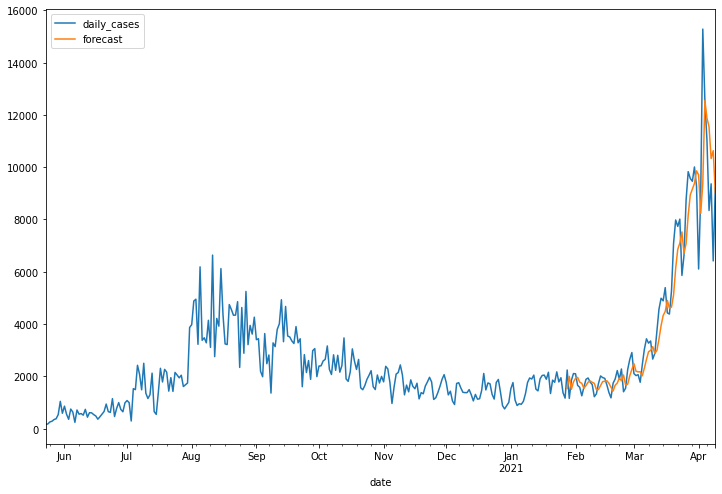

In [33]:
covid_ph['forecast'] = results.predict(start=250,end=325)
covid_ph[['daily_cases','forecast']].plot(figsize=(12,8))

In [34]:
results.forecast()

2021-04-10    10021.167773
Freq: D, dtype: float64

In [35]:
yhat = results.predict(start=310,end=322)
yhat

2021-03-29     9157.889859
2021-03-30     9380.149905
2021-03-31     9857.667563
2021-04-01     9706.747982
2021-04-02     8231.010292
2021-04-03     9376.241305
2021-04-04    12546.997615
2021-04-05    11880.485494
2021-04-06    11540.465595
2021-04-07    10330.042359
2021-04-08    10630.788644
2021-04-09     9023.160211
2021-04-10    10021.167773
Freq: D, dtype: float64

In [36]:
covid_ph.tail()

,daily_cases,Cases First Difference,forecast
date,,,
2021-04-05,11028,-1528.0,11880.485494
2021-04-06,8344,-2684.0,11540.465595
2021-04-07,9363,1019.0,10330.042359
2021-04-08,6414,-2949.0,10630.788644
2021-04-09,9216,2802.0,9023.160211
